In [2]:
from tensorflow.keras.models import load_model

MODEL_PATH = "../mentett_model/traffic_sign_model.h5"
model = load_model(MODEL_PATH)


1/1 [==============================] - 0s 26ms/step
                                  precision    recall  f1-score   support

                              30       1.00      0.92      0.96       249
                              50       1.00      1.00      1.00        18
                              60       1.00      0.83      0.91        87
                              70       0.91      1.00      0.95       154
                     elozniTilos       0.87      0.98      0.92       402
    keresztezodesAlarendeltUttal       0.93      0.84      0.88       192
                       foutvonal       0.91      1.00      0.95      1250
                   elsobbsegadas       0.96      0.89      0.92       744
                            stop       0.96      0.73      0.83       282
             mind2BehajtaniTilos       0.92      1.00      0.96        24
      teherautovalBehajtaniTilos       1.00      0.76      0.86        75
                  behajtaniTilos       0.81      0.94      

C:\Users\fabia\AppData\Local\Temp\ipykernel_19848\2066864761.py:85: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\fabia\anaconda3\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


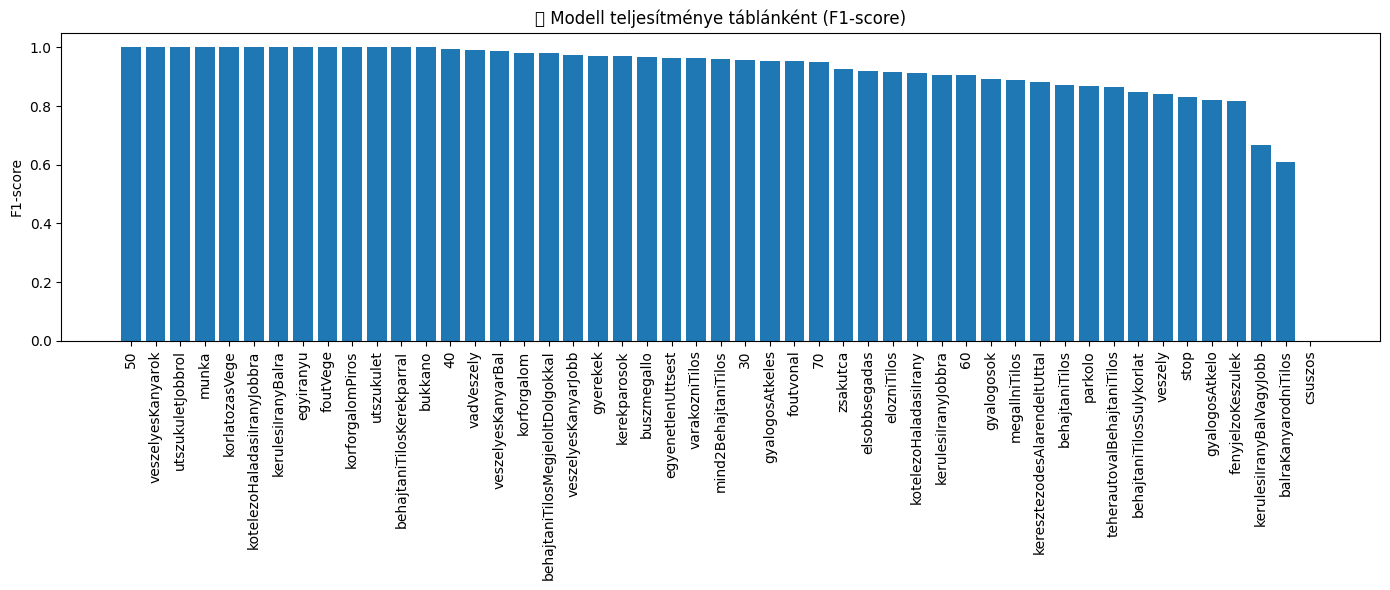

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

DATASET_PATH = Path("../MultiLabelFrames")
CSV_PATH = DATASET_PATH / "labels_filtered.csv"
MODEL_PATH = r"D:\Szakdolgozat\githubclone\kozlekedesi_tabla_felismero\mentett_model\traffic_sign_model.h5"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
THRESHOLD = 0.4

# Címkék betöltése
df = pd.read_csv(CSV_PATH)
sign_names = df.columns.drop("filename").tolist()
label_map = {name: i for i, name in enumerate(sign_names)}

# Dataset generáló
def gen():
    for _, row in df.iterrows():
        path = str(DATASET_PATH / row["filename"])
        label = row.drop("filename").values.astype("float32")
        yield path, label

# Előfeldolgozás
def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

# tf.data.Dataset létrehozása
ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(len(sign_names),), dtype=tf.float32)
    )
).map(preprocess).batch(BATCH_SIZE)

# Modell betöltése
model = load_model(MODEL_PATH)

# Előrejelzések
y_true = []
y_pred = []

for images, labels in ds:
    probs = model.predict(images)
    preds = (probs > THRESHOLD).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Jelentés kiírása
print(classification_report(np.array(y_true), np.array(y_pred), target_names=sign_names, zero_division=0))





report_dict = classification_report(
    np.array(y_true), np.array(y_pred),
    target_names=sign_names,
    zero_division=0,
    output_dict=True
)

# Kivesszük az F1-score-okat osztályonként
f1_scores = {label: metrics["f1-score"] for label, metrics in report_dict.items() if label in sign_names}

# Rendezés F1-score alapján
f1_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

# Ábra
plt.figure(figsize=(14, 6))
plt.bar(f1_sorted.keys(), f1_sorted.values())
plt.xticks(rotation=90)
plt.ylabel("F1-score")
plt.title("📈 Modell teljesítménye táblánként (F1-score)")
plt.tight_layout()
plt.show()
